# Full shape examples

In this notebook we will show how to perform full shape fits to data power spectrum, using Taylor expansion to speed likelihood evaluation.
Look first at notebooks basic_examples.ipynb to get a flavor of *cosmofit* behaviour, and bao_examples.ipynb for application to BAO fits.

## Fake power spectrum data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 1e-4
volume = 1e9

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)

## ShapeFit Likelihood

In [2]:
config = {}
config['like'] = {'class': 'cosmofit.likelihoods.galaxy_clustering.PowerSpectrumMultipolesLikelihood',
                  'init': {'data': mocks, 'covariance': mocks, 'covariance_scale': True,
                           'klim': {0: [0.02, 0.2], 2: [0.02, 0.2]},  # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                           'zeff': z, 'fiducial': 'DESI'}}
# Here we use Kaiser power spectrum for fast calculation,
#  but there is also LPTTracerPowerSpectrumMultipoles based on Velocileptors
config['tracer'] = {'class': 'cosmofit.theories.galaxy_clustering.KaiserTracerPowerSpectrumMultipoles',
                    'params': {'b1': {'ref': {'dist': 'uniform', 'limits': [1.99, 2.01]}}},
                               'sn0': {'ref': {'dist': 'uniform', 'limits': [-50., 50.]}}}
                    #'init': {'mu': 50}}  # only 50 mu (instead of 200) to speed up calculation in this notebook
config['param'] = {'class': 'cosmofit.theories.galaxy_clustering.ShapeFitPowerSpectrumParameterization',
                    'params': {'dm': {'ref': {'dist': 'uniform', 'limits': [-0.001, 0.001]}},
                               'f': {'ref': {'dist': 'uniform', 'limits': [0.85, 0.88]}},
                               'qp*r': {'ref': {'dist': 'uniform', 'limits': [0.998, 1.002]}}}}
config['cosmo'] = {'class': 'cosmofit.theories.primordial_cosmology.Cosmoprimo'}

# NOTE: if we wanted to fit xi instead:
# config['like'] = {'class': 'cosmofit.likelihoods.clustering.CorrelationFunctionMultipolesLikelihood',
#                   'init': {'data': data, 'covariance': mocks,
#                            'slim': {0: [40., 160], 2: [40., 160]},  # fit monopole and quadrupole, between 40 and 160 Mpc/h
#                            'zeff': z, 'fiducial': 'DESI'}}
# config['tracer'] = {'class': 'cosmofit.theories.clustering.KaiserTracerCorrelationFunctionMultipoles'}
# The rest would be the same

from cosmofit import LikelihoodPipeline, setup_logging

setup_logging()

likelihood = LikelihoodPipeline(config)

[000000.01] [0/1] 10-19 15:24  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/likelihoods/galaxy_clustering/power_spectrum.yaml
[000000.01] [0/1] 10-19 15:24  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/galaxy_clustering/full_shape.yaml
[000000.09] [0/1] 10-19 15:24  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/galaxy_clustering/power_template.yaml
[000000.12] [0/1] 10-19 15:24  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/primordial_cosmology.yaml
[000000.31] [0/1] 10-19 15:24  PowerSpectrumMultipolesLikelihood INFO     Covariance matrix with 36 points built from 1000 observations.
[000000.31] [0/1] 10-19 15:24  PowerSpectrumMultipolesLikelihood INFO     ...resulting in Hartlap fa

/home/adematti/.local/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000001.42] [0/1] 10-19 15:24  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000001.42] [0/1] 10-19 15:24  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000001.42] [0/1] 10-19 15:24  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000001.43] [0/1] 10-19 15:24  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000001.43] [0/1] 10-19 15:24  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
[000001.55] [0/1] 10-19 15:24  LikelihoodPipeline        INFO     Found likelihood like.


[000002.27] [0/1] 10-19 15:24  TaylorEmulator            INFO     Varied parameters: ['sn0', 'b1', 'f', 'dm', 'qpar', 'qper'].
[000002.27] [0/1] 10-19 15:24  TaylorEmulator            INFO     Found varying ['f_sqrt_Ap', 'm', 'DM_over_rd', 'DH_over_rd', 'DH_over_DM', 'DV_over_rd', 'power'] and fixed ['Ap', 'n', 'zeff', 'kp_rs', 'k', 'ells', 'fiducial'] outputs.
[000004.15] [0/1] 10-19 15:24  TaylorEmulator            INFO     Diagnostics:
[000004.17] [0/1] 10-19 15:24  BasePipeline              INFO     Found calculators [KaiserTracerPowerSpectrumMultipoles(None)].
[000004.17] [0/1] 10-19 15:24  BasePipeline              INFO     Found end calculators [KaiserTracerPowerSpectrumMultipoles(None)].
[000004.47] [0/1] 10-19 15:24  TaylorEmulator            INFO     - mse of f_sqrt_Ap is 0 (square root = 0).
[000004.47] [0/1] 10-19 15:24  TaylorEmulator            INFO     - mse of m is 4.51e-33 (square root = 6.71e-17).
[000004.47] [0/1] 10-19 15:24  TaylorEmulator            INFO     - mse

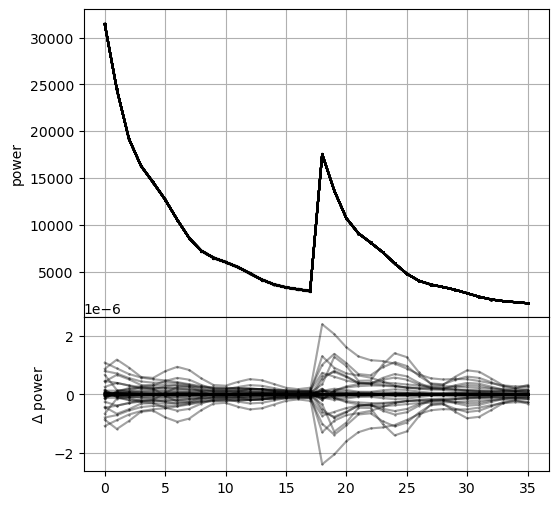

In [3]:
from cosmofit.base import BasePipeline
from cosmofit.emulators import TaylorEmulator

pipeline = likelihood.select('tracer', type=BasePipeline)
emulator = TaylorEmulator(pipeline, order={'*': 2, 'sn0': 1})  # order 2 except for sn0 (order 1 is enough)
emulator.set_samples()
emulator.fit()
emulator.check()
emulator.plot(name='power')

import os
base_dir = '_tests'
kaiser_emulator_fn = os.path.join(base_dir, 'kaiser_emulator.npy')
emulator.save(kaiser_emulator_fn)

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [4]:
from cosmofit.samplers import ZeusSampler

config['tracer']['load'] = kaiser_emulator_fn
del config['param'], config['cosmo']
likelihood = LikelihoodPipeline(config)

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.05})

[000005.10] [0/1] 10-19 15:24  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/likelihoods/galaxy_clustering/power_spectrum.yaml
[000005.11] [0/1] 10-19 15:24  TaylorEmulator            INFO     Loading _tests/kaiser_emulator.npy.
[000005.14] [0/1] 10-19 15:24  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/galaxy_clustering/full_shape.yaml
[000005.39] [0/1] 10-19 15:24  PowerSpectrumMultipolesLikelihood INFO     Covariance matrix with 36 points built from 1000 observations.
[000005.39] [0/1] 10-19 15:24  PowerSpectrumMultipolesLikelihood INFO     ...resulting in Hartlap factor of 0.9630.
[000005.39] [0/1] 10-19 15:24  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/galaxy_clustering/base.yaml
[000005.39] [0/1] 10-19 15:24  CalculatorConfig          INFO     No confi

[000702.73] [0/1] 10-19 15:36  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.076.
[000702.79] [0/1] 10-19 15:36  root                      INFO     Initialising ensemble of 16 walkers...
[000794.08] [0/1] 10-19 15:37  ZeusSampler               INFO     Diagnostics:
[000794.11] [0/1] 10-19 15:37  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0319; < 0.05.
[000794.14] [0/1] 10-19 15:37  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00556.
[000794.20] [0/1] 10-19 15:37  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0239.
[000794.21] [0/1] 10-19 15:37  ZeusSampler               INFO     - max Geweke is 0.181.
[000794.21] [0/1] 10-19 15:37  ZeusSampler               INFO     - Geweke p-value is 0.288.
[000794.30] [0/1] 10-19 15:37  ZeusSampler               INFO     - (1200 iterations / integrated autocorrelation time) (reliable) is 96.8.
[000794.30] [0/1] 10-19 15:3

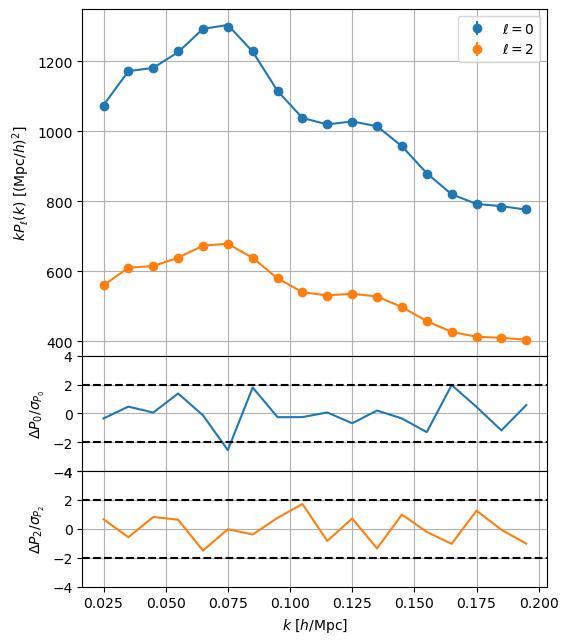

In [5]:
likelihood.run(**sampler.chains[0].choice())
likelihood.end_calculators[0].plot()
plt.show()

In [6]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+------+---------+----------+----------+---------+-----------------+-----------------+
|      | argmax  |   mean   |  median  |   std   | quantile:1sigma | interval:1sigma |
+------+---------+----------+----------+---------+-----------------+-----------------+
| sn0  |  -10.3  |   -9.1   |   -9.1   |   5.5   |    -5.4/+5.4    |    -5.5/+5.4    |
|  f   | 0.87504 | 0.87523  | 0.87523  | 0.00082 | -8.4e-4/+8.1e-4 | -9.1e-4/+7.4e-4 |
|  dm  | 0.00022 | -0.00016 | -0.00016 | 0.00097 | -9.8e-4/+9.9e-4 | -9.8e-4/+9.9e-4 |
| qpar | 1.00070 | 1.00078  | 1.00077  | 4.8e-4  | -4.8e-4/+4.8e-4 | -4.7e-4/+4.9e-4 |
| qper | 1.00210 | 1.00217  | 1.00216  | 0.00087 | -8.7e-4/+8.5e-4 | -8.9e-4/+8.3e-4 |
|  b1  | 1.9978  |  1.9979  |  1.9979  | 0.0015  | -0.0015/+0.0015 | -0.0013/+0.0016 |
+------+---------+----------+----------+---------+-----------------+-----------------+


[000794.75] [0/1] 10-19 15:37  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in
[000795.74] [0/1] 10-19 15:37  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000795.74] [0/1] 10-19 15:37  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000797.30] [0/1] 10-19 15:37  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000797.30] [0/1] 10-19 15:37  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


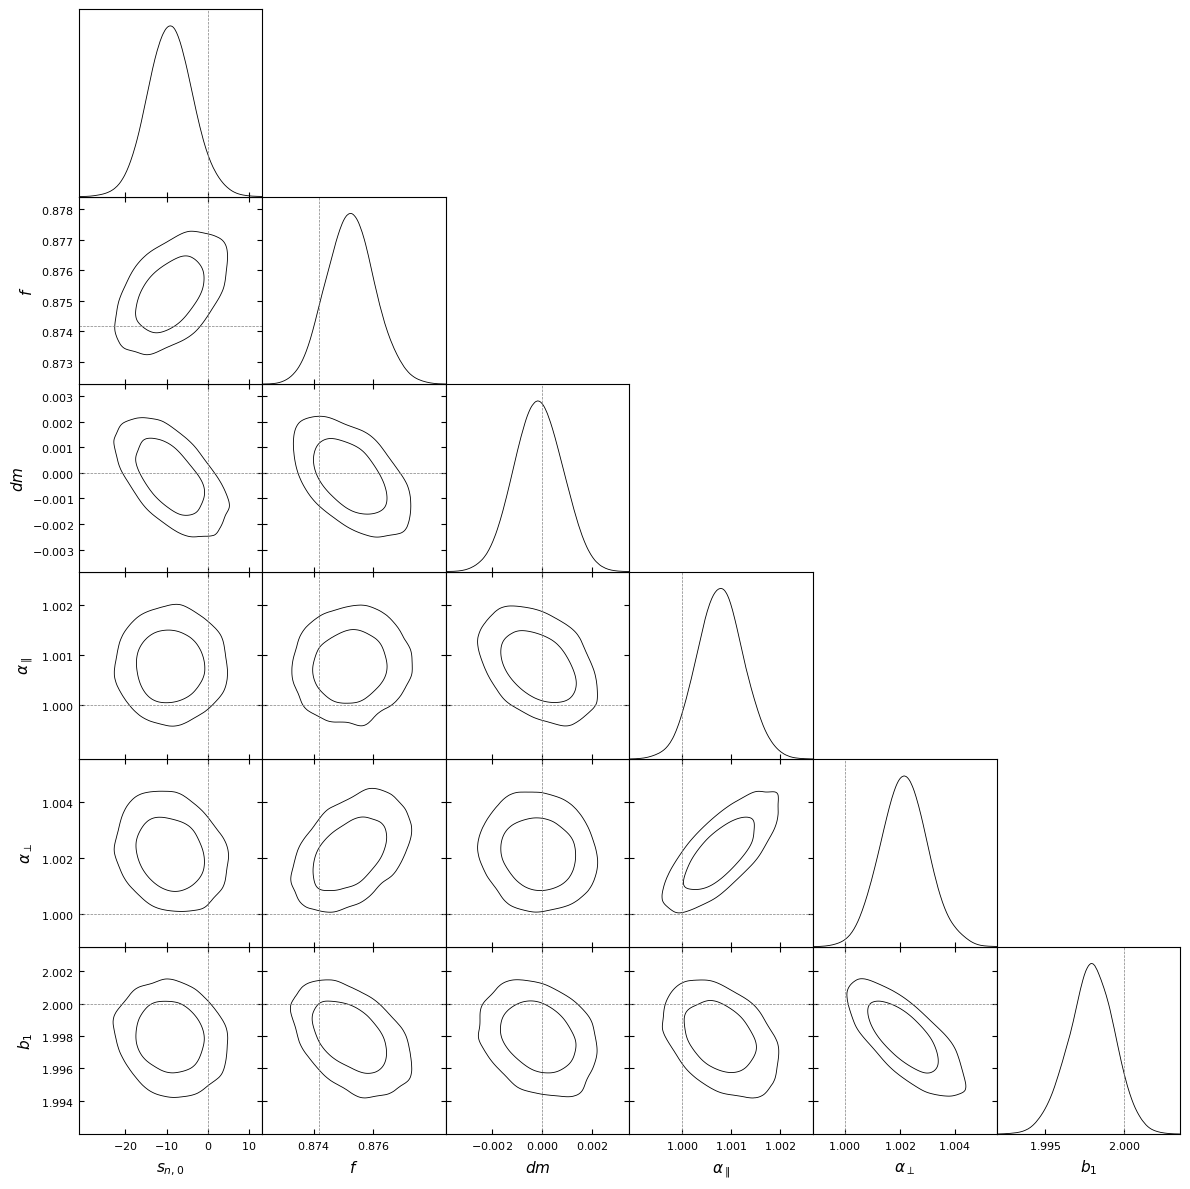

In [7]:
from cosmofit.samples import plotting
plotting.plot_triangle(chain, markers={'f': f, 'qpar': 1., 'qper': 1., 'dm': 0., 'b1': b, 'sn0': 0.})

## Post-processing

In [8]:
fs_chain = sampler.chains[0]

In [9]:
import os
base_dir = '_tests'
shapefit_emulator_fn = os.path.join(base_dir, 'shapefit_emulator.npy')

config = {}
config['like'] = {'class': 'cosmofit.likelihoods.galaxy_clustering.ShapeFitParameterizationLikelihood',
                  'init': {'source': {'fn': fs_chain, 'burnin': 0.5}}}
config['theory'] = {'class': 'cosmofit.likelihoods.galaxy_clustering.compressed.ShapeFitParameterizationTheory',
                    'emulator': {'save': shapefit_emulator_fn}}
config['cosmo'] = {'class': 'cosmofit.theories.primordial_cosmology.Cosmoprimo',
                   'init': {'fiducial': 'DESI'},
                   'params': {'.delete': 'omega_cdm',
                              'Omega_m': {'fixed': False, 'prior': {'dist': 'uniform', 'limits': [0.05, 0.6]},
                                          'ref': {'dist': 'uniform', 'limits': [0.30, 0.33]}, 'latex': '\Omega_{m}'},
                               'A_s': {'fixed': False, 'prior': {'dist': 'uniform', 'limits': [1.8e-9, 3e-9]},
                                       'ref': {'dist': 'uniform', 'limits': [1.9e-9, 2.1e-9]}},
                               'h': {'fixed': False, 'prior': {'dist': 'uniform', 'limits': [0.4, 0.9]},
                                     'ref': {'dist': 'uniform', 'limits': [0.65, 0.70]}}}}

In [10]:
likelihood = LikelihoodPipeline(config)

from cosmofit.emulators import EmulatorConfig
config_emulator = EmulatorConfig({'class': 'TaylorEmulator', 'init': {'order': 3}, 'sample': {'scale': 1e-1}, 'check': None})
config_emulator.run(likelihood.copy(type=BasePipeline))

[000797.75] [0/1] 10-19 15:37  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/primordial_cosmology.yaml
[000798.20] [0/1] 10-19 15:37  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/galaxy_clustering/power_template.yaml
[000798.25] [0/1] 10-19 15:37  LikelihoodPipeline        INFO     Found calculators [ShapeFitParameterizationLikelihood(like), ShapeFitParameterizationTheory(theory), Cosmoprimo(cosmo), BasePowerSpectrumWiggles(wiggles)].
[000798.25] [0/1] 10-19 15:37  LikelihoodPipeline        INFO     Found end calculators [ShapeFitParameterizationLikelihood(like)].


/home/adematti/.local/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000799.25] [0/1] 10-19 15:37  ShapeFitParameterizationLikelihood INFO     Fitting input samples [Parameter(DM_over_rd, fixed), Parameter(DH_over_rd, fixed), Parameter(m, fixed), Parameter(f_sqrt_Ap, fixed)].
[000799.26] [0/1] 10-19 15:37  LikelihoodPipeline        INFO     Found likelihood like.
[000802.35] [0/1] 10-19 15:37  TaylorEmulator            INFO     Varied parameters: ['Omega_m', 'A_s', 'h'].
[000802.35] [0/1] 10-19 15:37  TaylorEmulator            INFO     Found varying ['theory'] and fixed ['quantities'] outputs.
[000950.14] [0/1] 10-19 15:40  TaylorEmulator            INFO     Diagnostics:
[000950.16] [0/1] 10-19 15:40  BasePipeline              INFO     Found calculators [ShapeFitParameterizationTheory(None)].
[000950.16] [0/1] 10-19 15:40  BasePipeline              INFO     Found end calculators [ShapeFitParameterizationTheory(None)].
[000950.31] [0/1] 10-19 15:40  TaylorEmulator            INFO     - mse of theory is 4.3e-10 (square root = 2.07e-05).
[000950.31] [0/1]

In [11]:
config['theory']['load'] = shapefit_emulator_fn
likelihood = LikelihoodPipeline(config)

from cosmofit.samplers import ZeusSampler

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.05})

[000950.32] [0/1] 10-19 15:40  TaylorEmulator            INFO     Loading _tests/shapefit_emulator.npy.
[000950.34] [0/1] 10-19 15:40  CalculatorConfig          INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/primordial_cosmology.yaml
[000950.47] [0/1] 10-19 15:40  LikelihoodPipeline        INFO     Found calculators [ShapeFitParameterizationLikelihood(like), ShapeFitParameterizationTheory(theory)].
[000950.47] [0/1] 10-19 15:40  LikelihoodPipeline        INFO     Found end calculators [ShapeFitParameterizationLikelihood(like)].
[000950.47] [0/1] 10-19 15:40  ShapeFitParameterizationLikelihood INFO     Fitting input samples [Parameter(DM_over_rd, fixed), Parameter(DH_over_rd, fixed), Parameter(m, fixed), Parameter(f_sqrt_Ap, fixed)].
[000950.54] [0/1] 10-19 15:40  LikelihoodPipeline        INFO     Found likelihood like.
[000950.55] [0/1] 10-19 15:40  ZeusSampler               INFO     Varied parameters: ['Omega_m', 'A_s', 'h'].
[00095

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000993.66] [0/1] 10-19 15:40  ZeusSampler               INFO     Diagnostics:
[000993.67] [0/1] 10-19 15:40  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0229; < 0.05.
[000993.67] [0/1] 10-19 15:40  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00661.
[000993.69] [0/1] 10-19 15:40  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0632.
[000993.69] [0/1] 10-19 15:40  ZeusSampler               INFO     - max Geweke is 0.35.
[000993.70] [0/1] 10-19 15:40  ZeusSampler               INFO     - Geweke p-value is 0.196.
[000993.71] [0/1] 10-19 15:40  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) (reliable) is 64.9.
[000993.71] [0/1] 10-19 15:40  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.201.
[000993.74] [0/1] 10-19 15:40  root                      INFO     Initialising ensemble of 8 walkers...
[001014.56] [0/1] 10-19 15:41  

+---------+-----------+-----------+-----------+---------+-------------------+-------------------+
|         |  argmax   |   mean    |  median   |   std   |  quantile:1sigma  |  interval:1sigma  |
+---------+-----------+-----------+-----------+---------+-------------------+-------------------+
| Omega_m |  0.31703  |  0.31703  |  0.31705  | 0.00085 |  -8.5e-4/+8.3e-4  |  -8.9e-4/+7.8e-4  |
|   A_s   | 2.0984e-9 | 2.0983e-9 | 2.0983e-9 | 7.5e-12 | -7.5e-12/+7.6e-12 | -8.5e-12/+6.5e-12 |
|    h    |  0.67155  |  0.67156  |  0.67154  | 0.00091 |  -8.8e-4/+9.0e-4  |  -8.5e-4/+9.2e-4  |
+---------+-----------+-----------+-----------+---------+-------------------+-------------------+
Removed no burn in


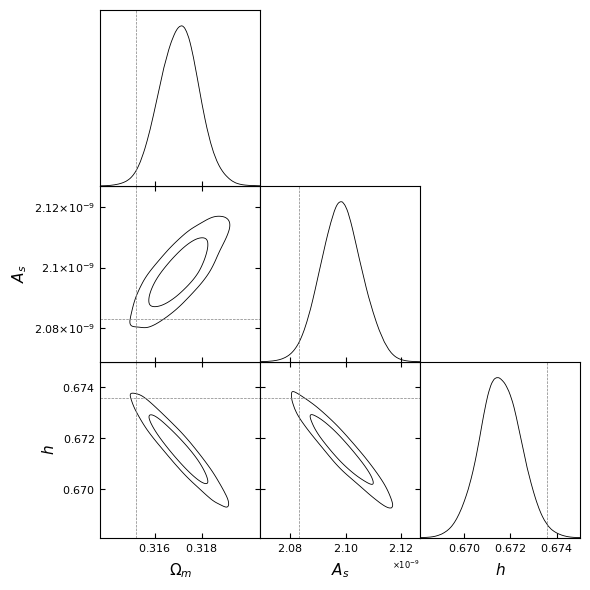

In [12]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))
plotting.plot_triangle(chain, markers={'Omega_m': cosmo.Omega0_m, 'A_s': cosmo.A_s, 'h': cosmo.h})